# Figure 3 & Supp. Fig. 3
The goal of this experiment is to ask if the history dependent component of the rotational OMR, which we established in Fig. S2DE, relies on the reafference, unlike in the forward OMR case (Fig. 2).

Fish experienced 5-s long closed-loop rotational motion (with gain of 0.5 or 1.5), followed by a 2-s waiting period and a 10-s open-loop rotation.

Please see **Table S1** for the detail of the stimulus structure.

In [1]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
import colorcet as cc
from scipy.stats import wilcoxon, binned_statistic
from homr_util import *
from scipy.signal import convolve
from tqdm import tqdm

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [8]:
# Find data
data_dir = "./data/fig3"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 36 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- Down sample data to 20 Hz
- Cut out snippet around each stimulus epoch, sort by epoch type## Data extraction
- Smooth turn data, because they look too "spiky"
- We are only interested in the relative directionality of priming and probe rotations. Such that, we will 'fold' data so that the probe direction is positive

In [9]:
bin_dt = 1/20   # downsampling to 20Hz
time_bin = np.arange(0, 22, bin_dt)  # each trial is 22 s long (5 s wait, 5 s conditioning, 2 s wait, 10 s probe)
binned_t = (time_bin[1:]+time_bin[:-1])/2

all_traces   = [] # theta (= image rotation) (not visualized in the end)
all_fvtraces = [] # turn velocity of the fish (before applying gain)

# Go through all fish
for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # Timestamps (stimulus presentation rate, 60 Hz-ish)
    t_s = exp.stimulus_log['t'].to_numpy()
    # Image orientations
    theta = exp.stimulus_log['seamless_image_theta'].to_numpy() / np.pi * 180
    # Fish turning spikes, pre-gain
    fv = exp.stimulus_log['seamless_image_fish_theta'].to_numpy() * exp.stimulus_log['seamless_image_start_theta_update'].to_numpy() / np.pi * 180# before gain, in radian
        
    # save structure 
    # 2 gain conditions x 2 priming/probe combination after folds
    traces   = [[] for i in range(4)] 
    fvtraces = [[] for i in range(4)] 
    
    # go through epochs
    for epoch in slog:
        
        # figure out condition
        pri_gain = epoch['gain_priming'] # low (0.5) or high (1.5)
        pri_dir = np.sign(epoch['vel_priming']) 
        pro_dir = np.sign(epoch['vel_probe'])
        # calculate ID (in the order of low gain contra, low gain syn, high gain contra, high gain syn)
        epoch_id = int(2.0 * (pri_gain>1.0) + 1.0 * (pri_dir==pro_dir))
                
        # calculate time stamps
        duration = epoch['duration']
        t_end = epoch['t_stop']
        
        # cut out snippets (trust end more than start)
        this_epoch_ind = (t_s>(t_end-duration)) * (t_s<=t_end)
        
        this_t = t_s[this_epoch_ind]
        this_t = this_t - (t_end - duration)
        this_th = theta[this_epoch_ind] * pro_dir # flipping
        this_th = this_th - this_th[0]
        this_fv = fv[this_epoch_ind] * pro_dir # flipping

        binned_th = binned_statistic(this_t, this_th, bins=time_bin)[0]
        binned_fv = binned_statistic(this_t, this_fv, statistic='sum', bins=time_bin)[0] / bin_dt
        
        # saving
        traces[epoch_id].append(binned_th)
        fvtraces[epoch_id].append(binned_fv)
    
    all_traces.append(traces)
    all_fvtraces.append(fvtraces)

100%|████████████████████████████████████████████████████████████████████████| 36/36 [00:09<00:00,  3.70it/s]


### Calculate trial-wise metrics 

In [10]:
# Conversion to numpy array 
all_traces   = np.asarray(all_traces)
all_fvtraces = np.asarray(all_fvtraces)

# smooth velocity, because this is just a pulse (only for time trace visualization purpose)
smoothing_window = 20 # 1 second window (20 samples x 20 Hz)
sm_fvtraces = convolve(np.ones((1, 1, 1, smoothing_window))/smoothing_window, all_fvtraces, method='direct')[:, :, :, :len(binned_t)]

# average velocity during probe for each fish, condition, trial
# to be correlated with the amount of reafference in priming
probe_mean_fv = np.nanmean(all_fvtraces[:, :, :, (binned_t>=12)*(binned_t<22)], axis=3)

## total angular displacement in the priming
# this is quantified by image rotation (i.e., it already reflects different gains)
pre_pos = np.nanmean(all_traces[:, :, :, (binned_t>11.0)*(binned_t<11.5)], axis=3)
# positive is the correct probe OMR direction (in syn-directional conditions)
pre_swim = 150*np.asarray((-1,1,-1,1))[None, :, None] - pre_pos 

# correlation of the two (per epoch type)
pre_probe_corr = np.empty((n_fish, 2))
for i in range(n_fish):
    for j in range(2):
        # angles turned
        C = np.corrcoef(probe_mean_fv[i, j::2, :].flatten(), pre_swim[i, j::2, :].flatten())
        pre_probe_corr[i, j] = C[0,1]

### Sort trials by priming behavior
- The goal is to, for each gain condition, pick trials where fish made comparable turning efforts during the priming period, and show that the gain does not affect probe behavior
- For each direction (i.e. syn or contra), we sort summed bout bias during probe into N bins (with gain conditions merged), and compare the gain conditions within each bin
- This is more complicated than the forward case (Fig. 2) where we could approximately think that any bout would bring fish forward

In [11]:
n_partition = 4

# For all trails in all fish, calculate (pre-bias) summed swim effort wihtin the priming phaes
probe_summed_laterality = np.nansum(all_fvtraces[:, :, :, (binned_t>=5)*(binned_t<10)], axis=3) * bin_dt

# lists of lists for data storage
sorted_probe_resp_ipsi = [[] for x in range(n_partition)]
sorted_pre_psl_ipsi = [[] for x in range(n_partition)]
sorted_probe_resp_contra = [[] for x in range(n_partition)]
sorted_pre_psl_contra = [[] for x in range(n_partition)]

# we go through partitions one by one
for k in range(n_partition):
    for i in range(n_fish):
        
        # disregard gain
        gain_merged_ipsi_psl   = probe_summed_laterality[i, (1, 3), :].flatten()
        gain_merged_contra_psl = probe_summed_laterality[i, (0, 2), :].flatten()
        
        # here, we discard minority of trials where fish rotated the other way around during the priming phase
        correct_gain_merged_ipsi_psl   = gain_merged_ipsi_psl[gain_merged_ipsi_psl>0]
        correct_gain_merged_contra_psl = gain_merged_contra_psl[gain_merged_contra_psl<0]
        
        # find upper & lower limits of summed primimng turn bias for this fish for this partition, 
        # separately for ipsi and contra directions. Note that all data are already flipped so that
        # ipsi is positive.
        lower_limit_ipsi = np.percentile(correct_gain_merged_ipsi_psl, 100/(n_partition+1)*k)
        upper_limit_ipsi = np.percentile(correct_gain_merged_ipsi_psl, 100/(n_partition+1)*(k+1))
        lower_limit_contra = np.percentile(correct_gain_merged_contra_psl, 100 - 100/(n_partition+1)*(k+1)) # these numbers are negative!
        upper_limit_contra = np.percentile(correct_gain_merged_contra_psl, 100 - 100/(n_partition+1)*k)

        # Find which trials meet the criteria
        low_gain_ipsi_in_bin_trial  = (probe_summed_laterality[i, 1, :] >= lower_limit_ipsi) * (probe_summed_laterality[i, 1, :] <= upper_limit_ipsi)
        high_gain_ipsi_in_bin_trial = (probe_summed_laterality[i, 3, :] >= lower_limit_ipsi) * (probe_summed_laterality[i, 3, :] <= upper_limit_ipsi)
        low_gain_contra_in_bin_trial  = (probe_summed_laterality[i, 0, :] >= lower_limit_contra) * (probe_summed_laterality[i, 0, :] <= upper_limit_contra)
        high_gain_contra_in_bin_trial = (probe_summed_laterality[i, 2, :] >= lower_limit_contra) * (probe_summed_laterality[i, 2, :] <= upper_limit_contra)

        # Average the selected probe trial behaviors, and save
        sorted_probe_resp_ipsi[k].append([np.mean(probe_mean_fv[i,1,:][low_gain_ipsi_in_bin_trial]),
                                          np.mean(probe_mean_fv[i,3,:][high_gain_ipsi_in_bin_trial])])
        sorted_probe_resp_contra[k].append([np.mean(probe_mean_fv[i,0,:][low_gain_contra_in_bin_trial]),
                                            np.mean(probe_mean_fv[i,2,:][high_gain_contra_in_bin_trial])])
                
        sorted_pre_psl_ipsi[k].append([np.mean(probe_summed_laterality[i,1,:][low_gain_ipsi_in_bin_trial]),
                                       np.mean(probe_summed_laterality[i,3,:][high_gain_ipsi_in_bin_trial])])
        sorted_pre_psl_contra[k].append([np.mean(probe_summed_laterality[i,0,:][low_gain_contra_in_bin_trial]),
                                         np.mean(probe_summed_laterality[i,2,:][high_gain_contra_in_bin_trial])])

# convert to numpy array
sorted_probe_resp_ipsi = np.asarray(sorted_probe_resp_ipsi)
sorted_probe_resp_contra = np.asarray(sorted_probe_resp_contra)
sorted_pre_psl_ipsi = np.asarray(sorted_pre_psl_ipsi)
sorted_pre_psl_contra = np.asarray(sorted_pre_psl_contra)

C:\Users\ryosuke\miniconda3\envs\ofmemory\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ryosuke\miniconda3\envs\ofmemory\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Calculate trial-averaged fish velocity and ipsi vs. contra Cohen's d

In [12]:
vtrial_mean = np.nanmean(sm_fvtraces, axis=2)
vdiff_mean = np.mean(vtrial_mean[:,(1,3),:] - vtrial_mean[:,(0,2),:], axis=0)
pooled_std = np.sqrt(0.5*(np.var(vtrial_mean[:,(1,3),:], axis=0) + np.var(vtrial_mean[:,(0,2),:], axis=0)))
cohens_d = vdiff_mean / pooled_std

### Make sure each quartile is similar across gain conditions

In [27]:
mean_psl_by_q = np.zeros((n_partition, 2, 2)) # Q, ipsi/contra, gain 
sem_psl_by_q = np.zeros((n_partition, 2, 2)) 
p_psl_by_q = np.zeros((n_partition, 2)) # Q, ipsi/contra

for i in range(n_partition): # go through quantiles
    
    ipsi_data = sorted_pre_psl_ipsi[i] # fish x gain
    contra_data = sorted_pre_psl_contra[i]
    
    # some bins can be empty, because we are binning quantiles disregarding gain conditions
    ipsi_good_fish = ~np.any(np.isnan(ipsi_data), axis=1)
    contra_good_fish = ~np.any(np.isnan(contra_data), axis=1)
    
    # calculate summary stats for visualization, and do signed rank test
    mean_psl_by_q[i, 0, :]   = np.mean(ipsi_data[ipsi_good_fish, :], axis=0)
    mean_psl_by_q[i, 1, :] = np.mean(contra_data[contra_good_fish, :], axis=0)
    sem_psl_by_q[i, :, 0]    = np.std(ipsi_data[ipsi_good_fish, :], axis=0) / np.sqrt(np.sum(ipsi_good_fish))
    sem_psl_by_q[i, :, 1]  = np.std(contra_data[contra_good_fish, :], axis=0) / np.sqrt(np.sum(contra_good_fish))
    
    p_psl_by_q[i, 0] = wilcoxon(np.diff(ipsi_data[ipsi_good_fish, :],axis=1))[1][0]
    p_psl_by_q[i, 1] = wilcoxon(np.diff(contra_data[contra_good_fish, :],axis=1))[1][0]

## Panels
### Fig. 3B (Average probe swim effort by conditions & by direction effect sizes)

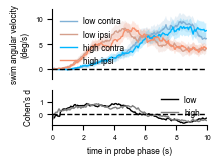

In [13]:
labels = ('low contra', 'low ipsi', 'high contra', 'high ipsi')
fig, ax= plt.subplots(2, 1, figsize=(2, 1.5), height_ratios=(2,1))

# average turning
for i in range(4):
    c_val = (0.5 + 0.5*float(i>1)) * ((i%2) - 0.5) + 0.5
    plot_mean_sem(ax[0], binned_t-12, vtrial_mean[:, i, :], color=cc.cm.CET_D11(c_val), label=labels[i])
ax[0].plot([0,10], [0,0], 'k--')
ax[0].set_ylim(-2, 12)
ax[0].set_ylabel('swim angular velocity\n(deg/s)')

# differences
for i in range(2):
    ax[1].plot(binned_t-12, cohens_d[i,:].T, color=(i/2,i/2,i/2), label=labels[i*2][:4])
ax[1].plot([0,10], [0,0], 'k--')

# axis management
for axx in ax:
    axx.set_xlim([-0, 10])
    axx.legend(frameon=False)
ax[1].set_xlabel('time in probe phase (s)')
ax[1].set_ylabel('Cohen\'s d')
toggle_spines(ax[0], 0, 0, 0, 1)
toggle_spines(ax[1], 0, 1, 0, 1)

plt.savefig('./svgs/Fig3B.svg', format='svg')
plt.show()

### Fig. 3CD (Example fish priming turn vs. probe swim effort & the correlation distribution, for *ipsi* primimng)

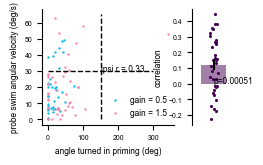

In [14]:
fid = 1 # example fish

fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5), width_ratios=(3, 1))

# Single fish, trial-wise data, primimng vs. probe
for i in range(2):
    ax[0].scatter(pre_swim[fid, 1+2*i, :], probe_mean_fv[fid, 1+2*i, :], s=3, color=cc.cm.CET_I3(255*i), label="gain = {:0.2}".format(i+0.5))
ax[0].text(150, 30, 'ipsi r = {:0.2}'.format(pre_probe_corr[fid,1]))
ax[0].plot([0,300],[30,30],'k--')
ax[0].plot([150,150],[0,65],'k--')
ax[0].set_xlabel('angle turned in priming (deg)')
ax[0].set_ylabel('probe swim angular velocity (deg/s)')
ax[0].legend()

# Distribution of priming-probe correlation
scatter_bar([pre_probe_corr[:,1]], ax=ax[1])
ax[1].text(0, 0, 'p={:0.2}'.format(wilcoxon(pre_probe_corr[:,1])[1]))
ax[1].set_ylabel('correlation')
ax[1].set_xlim([-0.7, 0.7])

toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 0, 0, 1)
    
plt.savefig('./svgs/Fig3CD.svg', format='svg')
plt.show()

### Fig. S3AB (Example fish priming turn vs. probe swim effort & the correlation distribution, for *contra* primimng)

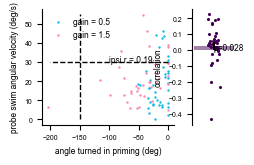

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(2.5, 1.5), width_ratios=(3, 1))

# Single fish, trial-wise data, primimng vs. probe
for i in range(2):
    ax[0].scatter(pre_swim[fid, 2*i, :], probe_mean_fv[fid, 2*i, :], color=cc.cm.CET_I3(255*i), label="gain = {:0.2}".format(i+0.5), s=3)
ax[0].text(-100, 30, 'ipsi r = {:0.2}'.format(pre_probe_corr[fid,0]))
ax[0].set_xlabel('angle turned in priming (deg)')
ax[0].set_ylabel('probe swim angular velocity (deg/s)')
ax[0].plot([0,-200],[30,30],'k--')
ax[0].plot([-150,-150],[0,55],'k--')
ax[0].legend()

# Distribution of priming-probe correlation
scatter_bar([pre_probe_corr[:,0]], ax=ax[1])
ax[1].text(0, 0, 'p={:0.2}'.format(wilcoxon(pre_probe_corr[:,0])[1]))
ax[1].set_ylabel('correlation')

toggle_spines(ax[0], 0, 1, 0, 1)
toggle_spines(ax[1], 0, 0, 0, 1)
    
plt.savefig('./svgs/FigS3AB.svg', format='svg')
plt.show()

### Fig. 3E (Mean probe turn by primimng gain, stratified by primimng swim effort - ipsi primimng)
- For similar amounts of turn effort in primimng, the two gain condition results in 3-fold differences in reafference

Q 0 : N = 35 fish p = 0.26
Q 1 : N = 25 fish p = 0.89
Q 2 : N = 29 fish p = 0.7
Q 3 : N = 27 fish p = 0.018


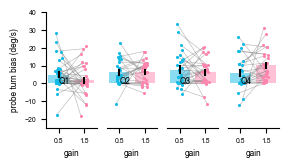

In [21]:
# stratify data by probe summed laterality (Ipsi data)
fig, ax = plt.subplots(1, n_partition, figsize=(3, 1.5))

# we ignore fish that did not have trials with all the bout numbers
# so that we can run paired statistical tests
for i in range(n_partition):
    this_data = sorted_probe_resp_ipsi[i]
    fish_to_use = ~np.any(np.isnan(this_data), axis=1)
    p = scatter_bar(this_data[fish_to_use, :].T, ax=ax[i], color=cc.cm.CET_I3, connect=True, condnames=('0.5', '1.5'))
    print('Q',i,': N =',np.sum(fish_to_use),'fish p =','{:0.2}'.format(p[0,1]))

for i in range(n_partition):
    toggle_spines(ax[i], 0, 1, 0, i==0)
    ax[i].set_ylim(-25, 40)
    ax[i].set_xlabel('gain')
    ax[i].text(0,0,'Q{}'.format(i+1))
ax[0].set_ylabel('probe turn bias (deg/s)')

plt.savefig('./svgs/Fig3E.svg', format='svg')
plt.show()

### Fig. S3C (Mean probe turn by primimng gain, stratified by primimng swim effort - contra primimng)
- For similar amounts of turn effort in primimng, the two gain condition results in 3-fold differences in reafference

Q 0 : N = 27 fish p = 0.86
Q 1 : N = 29 fish p = 0.83
Q 2 : N = 29 fish p = 0.15
Q 3 : N = 28 fish p = 0.17


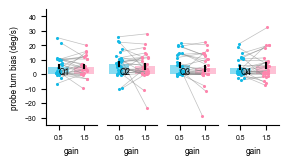

In [23]:
# stratify data by probe summed laterality (Contra data)
fig, ax = plt.subplots(1, n_partition, figsize=(3, 1.5))

# we ignore fish that did not have trials with all the bout numbers
# so that we can run paired statistical tests
for i in range(n_partition):
    this_data = sorted_probe_resp_contra[i]
    fish_to_use = ~np.any(np.isnan(this_data), axis=1)
    p = scatter_bar(this_data[fish_to_use, :].T, ax=ax[i], color=cc.cm.CET_I3, connect=True, condnames=('0.5', '1.5'))
    print('Q',i,': N =',np.sum(fish_to_use),'fish p =','{:0.2}'.format(p[0,1]))

for i in range(n_partition):
    toggle_spines(ax[i], 0, 1, 0, i==0)
    ax[i].set_ylim(-35, 45)
    ax[i].set_xlabel('gain')
    ax[i].text(0,0,'Q{}'.format(i+1))
ax[0].set_ylabel('probe turn bias (deg/s)')
plt.savefig('./svgs/FigS3C.svg', format='svg')

plt.show()

### Fig. S3D (Quality check for stratification of the priming behavior)

Q1 ipsi   across-gain primimng swim wilcoxon p=0.85
Q1 contra across-gain primimng swim wilcoxon p=0.75
Q2 ipsi   across-gain primimng swim wilcoxon p=0.22
Q2 contra across-gain primimng swim wilcoxon p=0.61
Q3 ipsi   across-gain primimng swim wilcoxon p=0.70
Q3 contra across-gain primimng swim wilcoxon p=0.69
Q4 ipsi   across-gain primimng swim wilcoxon p=0.56
Q4 contra across-gain primimng swim wilcoxon p=0.63


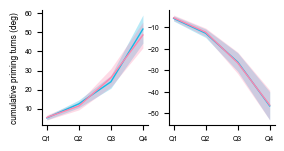

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(3, 1.5))

for i in range(2):
    for j in range(2):
        ax[i].fill_between(np.arange(4), mean_psl_by_q[:, i, j]-sem_psl_by_q[:, i, j],
                           mean_psl_by_q[:, i, j]+sem_psl_by_q[:, i, j], alpha=0.3, color=cc.cm.CET_I3(j*255))
        ax[i].plot(np.arange(4), mean_psl_by_q[:, i, j], color=cc.cm.CET_I3(j*255))
    ax[i].set_xticks(np.arange(4))
    ax[i].set_xticklabels(['Q{}'.format(i+1) for i in range(4)])
    toggle_spines(ax[i], 0, 1, 0, 1)
ax[0].set_ylabel('cumulative priming turns (deg)')

for i in range(4):
    print('Q{:} ipsi   across-gain primimng swim wilcoxon p={:0.2f}'.format(i+1, p_psl_by_q[i,0]))
    print('Q{:} contra across-gain primimng swim wilcoxon p={:0.2f}'.format(i+1, p_psl_by_q[i,1]))

plt.savefig('./svgs/FigS3D.svg', format='svg')
plt.show()